In [1]:
%load_ext autoreload
%autoreload 2

from MyClassifier_13 import MyClassifier
import numpy as np
import requests, gzip, os, hashlib
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rc('font', family='Times New Roman') 
matplotlib.rc('text', usetex='false') 
matplotlib.rcParams.update({'font.size': 16})

np.random.seed(1) # for reproducibility

In [2]:
### driver code
use_mnist = True# Set to True to use MNIST, False to use synthetic data (smaller and faster)
    
if use_mnist:
    # fetching the MNIST data

    ### change this line of code to put the data where you want it
    path = "./testing"
    os.makedirs(path, exist_ok=True)
    ###

    def fetch(url):
        fp = os.path.join(path, hashlib.md5(url.encode('utf-8')).hexdigest())
        if os.path.isfile(fp):
            with open(fp, "rb") as f:
                data = f.read()
        else:
            with open(fp, "wb") as f:
                data = requests.get(url).content
                f.write(data)
        return np.frombuffer(gzip.decompress(data), dtype=np.uint8).copy()

    y_train = fetch("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[0x10:].reshape((-1, 784))
    s_train = fetch("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]
    y_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")[0x10:].reshape((-1, 784))
    s_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")[8:]

    # taking only 1's and 7's
    y_train = y_train[(s_train == 1) | (s_train == 7)]
    s_train = s_train[(s_train == 1) | (s_train == 7)].astype(np.int8)
    y_test = y_test[(s_test == 1) | (s_test == 7)]
    s_test = s_test[(s_test == 1) | (s_test == 7)].astype(np.int8)

    # map 1's to s = 1 and 7's to s = -1
    s_train[s_train == 1] = 1
    s_train[s_train == 7] = -1
    s_test[s_test == 1] = 1
    s_test[s_test == 7] = -1

    #N_train = 1000 # reduce training size so it completes faster
    N_train = y_train.shape[0] # keep all training data

    # Randomly select and randomly order
    training_indices = np.random.choice(range(y_train.shape[0]), size=N_train, replace=False)
    y_train = y_train[training_indices]
    s_train = s_train[training_indices]

else:
    # synthetic dataset
    def make_dataset(N):
        Y = np.concatenate((np.random.multivariate_normal(np.array([-1,1]), np.identity(2), N//2), np.random.multivariate_normal(np.array([1,-1]), np.identity(2), N//2)))
        S = np.concatenate((-np.ones(N//2, dtype=np.int8), np.ones(N//2, dtype=np.int8)))
        order = list(range(Y.shape[0]))
        np.random.shuffle(order) # randomly order
        Y = Y[order]
        S = S[order]
        return (Y, S)

    N_train = 1000
    N_test = 1000

    y_train, s_train = make_dataset(N_train)
    y_test, s_test = make_dataset(N_test)
    

if use_mnist:
    filename = 'mnist'
else:
    filename = 'synth'
filename = filename + "_" + str(N_train)


In [3]:
print(y_train.shape)
print(s_train.shape)
print(y_test.shape)
print(s_test.shape)

# check for roughly equal amounts of training samples per class
print()
print((s_train[s_train == 1]).shape)
print((s_train[s_train == -1]).shape)

(13007, 784)
(13007,)
(2163, 784)
(2163,)

(6742,)
(6265,)


In [4]:
# define function
def percentage_correct(inferences, labels):
    N_test = inferences.shape[0]
    return 1/N_test * np.ones(N_test)@(labels == inferences)

In [5]:
# train all at once
model = MyClassifier(y_train.shape[1])
model.train(y_train, s_train)

inferences = model.test(y_test)
print("test dataset percent correct: {}".format(percentage_correct(inferences, s_test)))
# print(np.linalg.norm(model.W))

plot_range = 9
#fig = plt.figure(1)
if y_train.shape[1] == 2:
    # Original data
    x1 = [val[0] for val in y_train[s_train==-1]]
    y1 = [val[1] for val in y_train[s_train==-1]]

    x2 = [val[0] for val in y_train[s_train==1]]
    y2 = [val[1] for val in y_train[s_train==1]]
    
    x12 = np.array(x1 + x2)
    y12 = np.array(y1 + y2)
    c_data = np.array([0]*len(x1) + [1]*len(x2))
    data = np.transpose(np.stack((x12,y12,c_data)))
    np.random.shuffle(data)
    
    color = []
    for d in data[:,2]:
        color.append('blue') if d == 0 else color.append('orange')
    
    plt.scatter(data[:,0],data[:,1],c=color)

    x_plane = np.linspace(-plot_range, plot_range, 100)
    y_plane = -1/model.W[1] * (model.W[0]*x_plane + model.w)
    plt.plot(x_plane, y_plane, '--r',linewidth = 2)

    x_plane_margin1 = np.linspace(-plot_range, plot_range, 100)
    y_plane_margin1 = -1/model.W[1] * (model.W[0]*x_plane + model.w + 1)
    plt.plot(x_plane_margin1, y_plane_margin1, '-k',linewidth = 2)

    x_plane_margin2 = np.linspace(-plot_range, plot_range, 100)
    y_plane_margin2 = -1/model.W[1] * (model.W[0]*x_plane + model.w - 1)
    plt.plot(x_plane_margin2, y_plane_margin2, '-k',linewidth = 2)

    plt.gca().set_aspect('equal')
    plt.grid()
    plt.xlabel("$\mu_1$")
    plt.ylabel("$\mu_2$")
    plt.xlim([-5,5])
    plt.ylim([-5,5])
    plt.xticks([-4,-2,0,2,4])
    plt.yticks([-4,-2,0,2,4])
    
    
    
    plt.savefig('synth_whole_classifier.png', bbox_inches='tight', dpi=200)
    
    plt.show()

test dataset percent correct: 0.993065187239948


In [6]:
# train online
accuracy_vs_selected_samples_all_runs = []
selected_samples_vs_seen_samples_all_runs = []

num_iteration = 30

for _ in range(num_iteration): # average over multiple runs
    print(_)
    order = list(range(y_train.shape[0]))
    np.random.shuffle(order) # randomly order
    y_train = y_train[order]
    s_train = s_train[order]

    model = MyClassifier(y_train.shape[1])
    accuracy_vs_selected_samples = [] # indexed by number of training samples used
    selected_samples_vs_seen_samples = []

    inferences = model.test(y_test)
    accuracy_vs_selected_samples.append(percentage_correct(inferences, s_test)) # first element corresponds to 0 training samples
    selected_samples_vs_seen_samples.append(0)

    for i in range(len(y_train)):
        prev_size = model.y_train.shape[0]
        model.sample_selection(y_train[i], s_train[i])
        if model.y_train.shape[0] > prev_size:
            model.train()
            inferences = model.test(y_test)
            accuracy_vs_selected_samples.append(percentage_correct(inferences, s_test))
        selected_samples_vs_seen_samples.append(model.y_train.shape[0])

    accuracy_vs_selected_samples_all_runs.append(accuracy_vs_selected_samples)
    selected_samples_vs_seen_samples_all_runs.append(selected_samples_vs_seen_samples)

accuracy_vs_seen_samples_all_runs = []
for selected_samples_vs_seen_samples, accuracy_vs_selected_samples in zip(selected_samples_vs_seen_samples_all_runs, accuracy_vs_selected_samples_all_runs):
    accuracy_vs_selected_samples = np.array(accuracy_vs_selected_samples)
    accuracy_vs_seen_samples_all_runs.append(accuracy_vs_selected_samples[selected_samples_vs_seen_samples])

accuracy_vs_seen_samples_all_runs = np.array(accuracy_vs_seen_samples_all_runs)
avg_accuracy_vs_seen_samples = np.mean(accuracy_vs_seen_samples_all_runs, axis=0)

selected_samples_vs_seen_samples_all_runs = np.array(selected_samples_vs_seen_samples_all_runs)
avg_selected_samples_vs_seen_samples = np.mean(selected_samples_vs_seen_samples_all_runs, axis=0)

avg_accuracy_vs_selected_samples = [] # only average up until the last sample for the run with the least samples
for i in range(np.amin(list(len(accuracy_vs_selected_samples_all_runs[i]) for i in range(len(accuracy_vs_selected_samples_all_runs))))):
    avg_accuracy_vs_selected_samples.append(np.mean(list(accuracy_vs_selected_samples_all_runs[j][i] for j in range(len(accuracy_vs_selected_samples_all_runs)))))
avg_accuracy_vs_selected_samples = np.array(avg_accuracy_vs_selected_samples)

assert(y_train.shape[0] == len(avg_selected_samples_vs_seen_samples)-1) # sanity check
print("On average, used {} out of {} samples ({}%)".format(np.mean(avg_selected_samples_vs_seen_samples[-1]), y_train.shape[0], 100*np.mean(avg_selected_samples_vs_seen_samples[-1])/y_train.shape[0]))

# average accuracy after training the last sample in each run
print("Average accuracy: {}".format(np.mean(list(accuracy_vs_selected_samples_all_runs[i][-1] for i in range(len(accuracy_vs_selected_samples_all_runs))))))

0
1


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/cvxpy/problems/problem.py:1294: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
On average, used 329.23333333333335 out of 13007 samples (2.531201148099741%)
Average accuracy: 0.9901679765757468


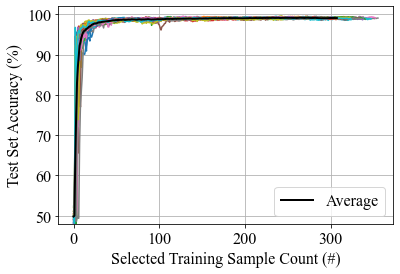

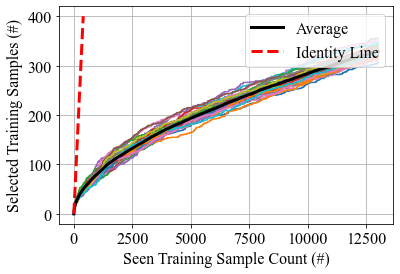

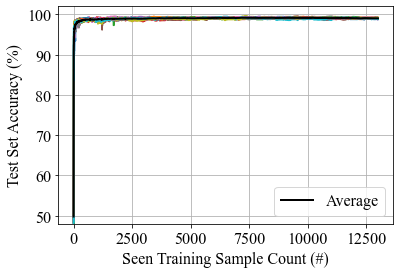

On average, reaches 50.0% accuracy after these training sample counts: [2]
On average, reaches 65.0% accuracy after these training sample counts: [3]
On average, reaches 80.0% accuracy after these training sample counts: [4]
On average, reaches 95.0% accuracy after these training sample counts: [11]


In [7]:
for accuracy_vs_selected_samples in accuracy_vs_selected_samples_all_runs:
    accuracy_vs_selected_samples = np.array(accuracy_vs_selected_samples)
    plt.plot(list(range(len(accuracy_vs_selected_samples))), accuracy_vs_selected_samples*100)
plt.plot(list(range(len(avg_accuracy_vs_selected_samples))), avg_accuracy_vs_selected_samples*100, color='black', linewidth=2, label='Average')
plt.xlabel("Selected Training Sample Count (#)")
plt.ylabel("Test Set Accuracy (%)")
plt.legend(loc = 'lower right')
plt.grid()
plt.ylim([48, 102])
plt.savefig(filename + "_alg_acc_vs_sel.png", bbox_inches='tight', dpi=200)
plt.show()

for selected_samples_vs_seen_samples in selected_samples_vs_seen_samples_all_runs:
    plt.plot(list(range(len(selected_samples_vs_seen_samples))), selected_samples_vs_seen_samples)
plt.plot(list(range(len(avg_selected_samples_vs_seen_samples))), avg_selected_samples_vs_seen_samples, color='black', linewidth=3, label='Average')
plt.plot([0,400],[0,400],'--r',label='Identity Line', linewidth=3)
plt.xlabel("Seen Training Sample Count (#)")
plt.ylabel("Selected Training Samples (#)")
plt.legend(loc = 'upper right')
#plt.gca().set_aspect('equal')
plt.grid() 
#plt.ylim([0, N_train/2])
plt.savefig(filename + "_alg_sel_vs_seen.png", bbox_inches='tight', dpi=200)
plt.show()

for accuracy_vs_seen_samples in accuracy_vs_seen_samples_all_runs:
    plt.plot(list(range(len(accuracy_vs_seen_samples))), accuracy_vs_seen_samples*100)
plt.plot(list(range(len(avg_accuracy_vs_seen_samples))), avg_accuracy_vs_seen_samples*100, color='black', linewidth=2, label='Average')
plt.xlabel("Seen Training Sample Count (#)")
plt.ylabel("Test Set Accuracy (%)")
plt.legend(loc = 'lower right')
plt.grid()
plt.ylim([48, 102])
plt.savefig(filename + "_alg_acc_vs_seen.png", bbox_inches='tight', dpi=200)
plt.show()

thresholds = [0.50, 0.65, 0.80, 0.95]
crossing_points = {}
for threshold in thresholds:
    crossing_points[threshold] = []
    under_threshold = True
    for i in range(len(avg_accuracy_vs_selected_samples)):
        if under_threshold and avg_accuracy_vs_selected_samples[i] >= threshold:
            crossing_points[threshold].append(i)
            under_threshold = False
        elif avg_accuracy_vs_selected_samples[i] < threshold:
            under_threshold = True
    print("On average, reaches {}% accuracy after these training sample counts: {}".format(threshold*100, crossing_points[threshold]))

if y_train.shape[1] == 2:
    # Selected data
    x1 = [val[0] for val in model.y_train[model.s_train==-1]]
    y1 = [val[1] for val in model.y_train[model.s_train==-1]]
    #plt.scatter(x1, y1)

    x2 = [val[0] for val in model.y_train[model.s_train==1]]
    y2 = [val[1] for val in model.y_train[model.s_train==1]]
    #plt.scatter(x2, y2)
    
    #print(len(x1))
    
    x12 = np.array(x1 + x2)
    y12 = np.array(y1 + y2)
    c_data = np.array([0]*len(x1) + [1]*len(x2))
    data = np.transpose(np.stack((x12,y12,c_data)))
    np.random.shuffle(data)
    
    color = []
    for d in data[:,2]:
        color.append('blue') if d == 0 else color.append('orange')
    
    plt.scatter(data[:,0],data[:,1],c=color)

    x_plane = np.linspace(-5,5, 100)
    y_plane = -1/model.W[1] * (model.W[0]*x_plane + model.w)
    plt.plot(x_plane, y_plane, '--r',linewidth = 2)

    x_plane_margin1 = np.linspace(-5,5, 100)
    y_plane_margin1 = -1/model.W[1] * (model.W[0]*x_plane + model.w + 1)
    plt.plot(x_plane_margin1, y_plane_margin1, '-k',linewidth = 2)

    x_plane_margin2 = np.linspace(-5,5, 100)
    y_plane_margin2 = -1/model.W[1] * (model.W[0]*x_plane + model.w - 1)
    plt.plot(x_plane_margin2, y_plane_margin2, '-k',linewidth = 2)

    plt.gca().set_aspect('equal')
    plt.grid()
    plt.xlabel("$\mu_1$")
    plt.ylabel("$\mu_2$")
    plt.xlim([-5,5])
    plt.ylim([-5,5])  
    plt.xticks([-4,-2,0,2,4])
    plt.yticks([-4,-2,0,2,4])

    plt.savefig(filename + "_alg_classifier_ex", bbox_inches='tight', dpi=200)
    plt.show()

In [8]:
# Choose the same number samples as selected by the algorithm for each run, but randomly
accuracy_vs_trained_samples_all_runs = []

for accuracy_vs_selected_samples in accuracy_vs_selected_samples_all_runs:
    num_samples = len(accuracy_vs_selected_samples)-1
    rand_train_indices = np.random.choice(range(y_train.shape[0]), size=num_samples, replace=False)
    rand_y_train = y_train[rand_train_indices]
    rand_s_train = s_train[rand_train_indices]

    model = MyClassifier(y_train.shape[1])
    accuracy_vs_trained_samples = []

    inferences = model.test(y_test)
    accuracy_vs_trained_samples.append(percentage_correct(inferences, s_test))

    for i in range(num_samples):
        print(i)
        model.train(rand_y_train[0:i+1], rand_s_train[0:i+1])
        inferences = model.test(y_test)
        accuracy_vs_trained_samples.append(percentage_correct(inferences, s_test))

    accuracy_vs_trained_samples_all_runs.append(accuracy_vs_trained_samples)

avg_accuracy_vs_trained_samples = [] # only average up until the last sample for the run with the least samples
for i in range(np.amin(list(len(accuracy_vs_trained_samples_all_runs[i]) for i in range(len(accuracy_vs_trained_samples_all_runs))))):
    avg_accuracy_vs_trained_samples.append(np.mean(list(accuracy_vs_trained_samples_all_runs[j][i] for j in range(len(accuracy_vs_trained_samples_all_runs)))))
avg_accuracy_vs_trained_samples = np.array(avg_accuracy_vs_trained_samples)

# average accuracy after training the last sample in each run
print("Average accuracy: {}".format(np.mean(list(accuracy_vs_trained_samples_all_runs[i][-1] for i in range(len(accuracy_vs_trained_samples_all_runs))))))




0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
24

212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
15

118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72

64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322


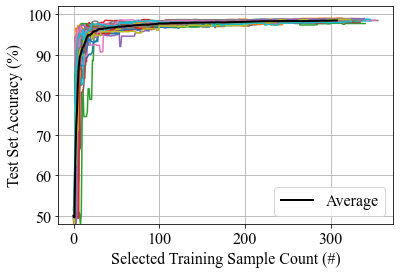

On average, reaches 50.0% accuracy after these training sample counts: [2]
On average, reaches 65.0% accuracy after these training sample counts: [3]
On average, reaches 80.0% accuracy after these training sample counts: [5]
On average, reaches 95.0% accuracy after these training sample counts: [20]


In [9]:
for accuracy_vs_trained_samples in accuracy_vs_trained_samples_all_runs:
    accuracy_vs_trained_samples = np.array(accuracy_vs_trained_samples)
    plt.plot(list(range(len(accuracy_vs_trained_samples))), accuracy_vs_trained_samples*100)
plt.plot(list(range(len(avg_accuracy_vs_trained_samples))), avg_accuracy_vs_trained_samples*100, color='black', linewidth=2, label='Average')
plt.xlabel("Selected Training Sample Count (#)")
plt.ylabel("Test Set Accuracy (%)")
plt.legend(loc = 'lower right')
plt.grid()
plt.ylim([48, 102])
plt.savefig(filename + "_rand_alg_acc_vs_train.png", bbox_inches='tight', dpi=200)
plt.show()

thresholds = [0.50, 0.65, 0.80, 0.95]
crossing_points = {}
for threshold in thresholds:
    crossing_points[threshold] = []
    under_threshold = True
    for i in range(len(avg_accuracy_vs_trained_samples)):
        if under_threshold and avg_accuracy_vs_trained_samples[i] >= threshold:
            crossing_points[threshold].append(i)
            under_threshold = False
        elif avg_accuracy_vs_trained_samples[i] < threshold:
            under_threshold = True
    print("On average, reaches {}% accuracy after these training sample counts: {}".format(threshold*100, crossing_points[threshold]))

In [10]:
def choose_data(y,s, ratio_to_use):
    N = y.shape[0]
    idxes = np.random.choice(N, size=int(N*ratio_to_use), replace=False)
    y_select = np.take(y, idxes, axis=0)  
    s_select = np.take(s, idxes, axis=0)
    return y_select, s_select

In [11]:
percentage_list = [0.001,0.002,0.003, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
percentage_correct_list = []
for n in percentage_list:
    y_train_select, s_train_select = choose_data(y_train,s_train, n)
    # train all at once
    model = MyClassifier(y_train.shape[1])
    model.train(y_train_select, s_train_select)
    inferences = model.test(y_test)
    percentage_correct_list.append(percentage_correct(inferences, s_test))

Text(0, 0.5, 'Percentage of correct inference on test data (%)')

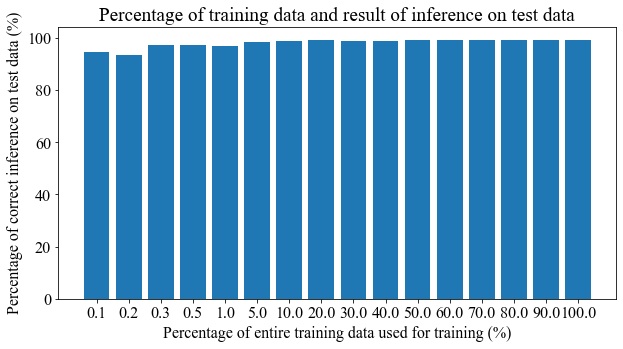

In [12]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.bar([str(p*100) for p in percentage_list], [p*100 for p in percentage_correct_list])
ax.set_title('Percentage of training data and result of inference on test data')
ax.set_xlabel('Percentage of entire training data used for training (%)')
ax.set_ylabel('Percentage of correct inference on test data (%)')
# Not sure what to make of these results; Is it overfitting at around 40% and then generalizing???

In [13]:
def show_test_result(i,ax):
    im = y_test[i].reshape(28,28)
    ax.imshow(im)
    if inferences[i] == 1:
        ax.set_title('1')
    elif inferences[i] == -1:
        ax.set_title('7')

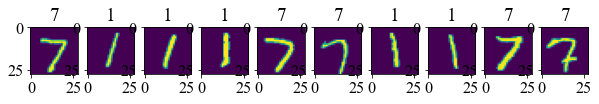

In [14]:
fig, axes = plt.subplots(1,10, figsize=(10,10))
for i, ax in enumerate(axes):
    show_test_result(i, ax)
    